In [1]:
import pandas as pd
import cufflinks as cf
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize as opt
from scipy.integrate import odeint
from IPython.display import display
cf.go_offline()
import re

In [2]:
source = "https://raw.githubusercontent.com/tomwhite/covid-19-uk-data/master/data/covid-19-cases-uk.csv"

utla_raw = pd.read_csv(source) # Raw Upper Tier Local Authority (UTLA) Case Counts
utla_raw.to_csv("dailycases.csv")

In [3]:
utla_raw = pd.read_csv("dailycases.csv", index_col=0)

In [4]:
def str2num(s):
    
    '''
    float <- str
    
    Accounts for irregular phrases such as '1 to 4' in the counts data
    by taking the mean of all integers occuring in the phrase.
    '''
    
    assert type(s) is str, "Case counts is not a string"
    counts = [int(n) for n in s.split() if s.isdigit()]
    if len(counts):
        return np.mean(counts)
    return np.nan
        
utla_raw.TotalCases = [str2num(s) for s in utla_raw.TotalCases]
utla_raw.dropna(subset=['TotalCases'],inplace=True)
utla_raw.Date = pd.to_datetime(utla_raw.Date)
utla_raw = utla_raw[utla_raw.Date < pd.to_datetime('today').strftime("%m/%d/%Y")] # remove today's data as it seems to be underreported

In [5]:
display(utla_raw)

,Date,Country,AreaCode,Area,TotalCases
0,2020-03-01,Scotland,S08000015,Ayrshire and Arran,0.0
1,2020-03-01,Scotland,S08000016,Borders,0.0
2,2020-03-01,Scotland,S08000017,Dumfries and Galloway,0.0
3,2020-03-01,Scotland,S08000029,Fife,0.0
4,2020-03-01,Scotland,S08000019,Forth Valley,0.0
...,...,...,...,...,...
4140,2020-03-28,Wales,W11000025,Hywel Dda,54.0
4141,2020-03-28,Wales,W11000024,Powys,19.0
4142,2020-03-28,Wales,W11000031,Swansea Bay,104.0
4143,2020-03-28,Wales,NaN,Resident outside Wales,6.0


In [6]:
fig = utla_raw.groupby('Date').sum().iplot(asFigure = True, 
                                           title="Case count UK",
                                           yTitle="Total cases",
                                           xTitle="Date")
fig.show()

In [7]:
# Cases by country

fig = utla_raw.groupby(['Date','Country']).sum().unstack().iplot(asFigure = True, 
                                           title="Case count UK",
                                           yTitle="Total cases (log)",
                                           xTitle="Date")

fig.update_layout(yaxis_type="log")
fig.show()

In [8]:
# Cases in England by UTLA

fig = utla_raw[utla_raw.Country=="England"].groupby(['Date','Area']).sum().unstack().iplot(asFigure = True, 
                                           title="Case count (England)",
                                           yTitle="Total cases (log)",
                                           xTitle="Date")

fig.update_layout(yaxis_type="log")
fig.show()

In [9]:
# Most affected cities in England

utla_raw[utla_raw.Country=="England"].groupby('Area').max().sort_values(by='TotalCases',ascending=False)

,Date,Country,AreaCode,TotalCases
Area,,,,
Birmingham,2020-03-28,England,E08000025,428.0
Hampshire,2020-03-28,England,E10000014,384.0
Sheffield,2020-03-28,England,E08000019,361.0
Southwark,2020-03-28,England,E09000028,319.0
Lambeth,2020-03-28,England,E09000022,318.0
...,...,...,...,...
Rutland,2020-03-28,England,E06000017,2.0
City of London,2020-03-05,England,E09000001,0.0
Isles of Scilly,2020-03-05,England,E06000053,0.0


In [30]:
len(city.TotalCases)

14

In [10]:
## Cleanup

target = "Sheffield"

# Remove days where cumulative cases fell as likely erroneous

city = utla_raw[utla_raw.Area==target][['Date','TotalCases']]
diffs = city.TotalCases[1:].values - city.TotalCases[:-1].values
city['Incidence'] = np.insert(diffs,0,0)
city = city[city.Incidence >0]

# Begin trace from first incident

city = city[city.TotalCases>0]

# Get average incidence for day to account for longer periods without incidence data

city['Intervals'] = pd.to_datetime(city.Date).diff().dt.days
city['Intervals'].iloc[0] = 1
city['IncidenceRate'] = city['Incidence']/city['Intervals']

# View

city['Time'] = city.Intervals.cumsum()-1
city


,Date,TotalCases,Incidence,Intervals,IncidenceRate,Time
1070,2020-03-11,1.0,1.0,1.0,1.0,0.0
1465,2020-03-13,3.0,2.0,2.0,1.0,2.0
1646,2020-03-14,13.0,10.0,1.0,10.0,3.0
2010,2020-03-16,15.0,3.0,2.0,1.5,5.0
2377,2020-03-18,36.0,35.0,2.0,17.5,7.0
2538,2020-03-19,40.0,4.0,1.0,4.0,8.0
2891,2020-03-21,61.0,21.0,2.0,10.5,10.0
3061,2020-03-22,82.0,21.0,1.0,21.0,11.0
3231,2020-03-23,106.0,24.0,1.0,24.0,12.0
3401,2020-03-24,130.0,24.0,1.0,24.0,13.0


In [11]:
# Plot cleaned data

fig = city.iplot(x='Date', y='TotalCases',
                 asFigure = True, 
                 title="Case count " + target,
                 yTitle="Total cases",
                 xTitle="Date")

fig.add_trace(go.Bar(x=city.Date, y=city.IncidenceRate, name='Incidence Rate'))
fig.show()

In [12]:
def GLM(t, r, p, K, C_0 = 1):
    def GLM_ode(C_t, t):
        return r*pow(C_t, p)*(1-C_t/K)
    GLM_int = odeint(GLM_ode, C_0, t)
    return GLM_int[:,0]

pop = (10**6)/2 # Population of Sheffield

param_GLM, param_cov = opt.curve_fit(GLM,
                                 city.Time,
                                 city.TotalCases,
                                 p0=[0.8, 1.0, pop*0.2],
                                 bounds=([0,0,max(city.TotalCases)*2],[10,1,pop*0.8]))

param_GLM_sds = np.sqrt(np.diag(param_cov))

In [13]:
lookahead = 7

interval = city.Date.iloc[-1] - city.Date.iloc[0]
times = range(interval.days+lookahead)

est_total_cases_GLM = GLM(times, r = param_GLM[0], p = param_GLM[1], K = param_GLM[2])
upp_total_cases_GLM = GLM(times, r = param_GLM[0]+param_GLM_sds[0], p = param_GLM[1]+param_GLM_sds[1], K = param_GLM[2])
low_total_cases_GLM = GLM(times, r = param_GLM[0]-param_GLM_sds[0], p = param_GLM[1]-param_GLM_sds[1], K = param_GLM[2])

est_daily_cases_GLM = np.diff(est_total_cases_GLM)

dates = pd.date_range(start=city.Date.iloc[0],periods=interval.days+lookahead)

In [14]:
def RM(t, r, a, K, C_0 = 1):
    def RM_ode(C_t, t):
        return r*C_t*(1-pow(C_t/K,a))
    RM_int = odeint(RM_ode, C_0, t)
    return RM_int[:,0]

pop = (10**6)/2 # Population of Sheffield

param_RM, param_cov = opt.curve_fit(RM,
                                 city.Time,
                                 city.TotalCases,
                                 p0=[0.8, 1.0, pop*0.2],
                                 bounds=([0,0,max(city.TotalCases)*2],[10,10,pop*0.8]))

param_RM_sds = np.sqrt(np.diag(param_cov))

In [15]:
lookahead = 7

interval = city.Date.iloc[-1] - city.Date.iloc[0]
times = range(interval.days+lookahead)

est_total_cases_RM = RM(times, r = param_RM[0], a = param_RM[1], K = param_RM[2])
upp_total_cases_RM = RM(times, r = param_RM[0]+param_RM_sds[0], a = param_RM[1]+param_RM_sds[1], K = param_RM[2])
low_total_cases_RM = RM(times, r = param_RM[0]-param_RM_sds[0], a = param_RM[1]-param_RM_sds[1], K = param_RM[2])

est_daily_cases_RM = np.diff(est_total_cases_RM)

dates = pd.date_range(start=city.Date.iloc[0],periods=interval.days+lookahead)

In [16]:
# Plot fitted data

fig = city.iplot(x='Date', y='TotalCases',
                 mode = 'lines+markers',
                 asFigure = True, 
                 title="Case count " + target,
                 yTitle="Total cases",
                 xTitle="Date")

fig.add_trace(go.Scatter(x=dates, y=est_total_cases_GLM, name='EstTotalCases (GLM)'))
fig.add_trace(go.Scatter(x=dates, y=est_total_cases_RM, name='EstTotalCases (RM)'))

fig.add_trace(go.Bar(x=city.Date, y=city.IncidenceRate, name='Incidence Rate'))
fig.add_trace(go.Bar(x=dates, y=est_daily_cases_GLM, name='Est Incidence Rate (GLM)'))
fig.add_trace(go.Bar(x=dates, y=est_daily_cases_RM, name='Est Incidence Rate (RM)'))

fig.show()

In [17]:
## Bootstrap confidence intervals

def param_sd(total_cases, model, pop, S=100):
    
    '''
    (np array)<-(np array, epi_model, int, int)
    Takes in a predicted cumulative case array, model and bootstrap iterations.
    1. Get predicted daily incidents
    2. Initialise parameter sums and parameters squared sum (sufficient stats to compute stdev)
    3. For each bootstrap:
        - For each day, draw x~Poisson(mu) with mu = predicted incidents on day
        - Generate a new cumulative case array
        - Fit model to this array
        - Add params to sum params, sum sq params
    4. Compute and return standard deviation from the sufficient stats
    '''
    
    # Step 1: Daily incidents
    
    daily = np.diff(total_cases)
    times = range(len(daily)+1)
    
    # Step 2: Initiaise param counts
    # When we have a model class we can use np.zeros(model.npars)
    
    paramsums = np.zeros(len(model.__code__.co_cellvars))
    paramsumsqs = np.zeros(len(model.__code__.co_cellvars))
    
    paramouts = []
    
    # Step 3: Bootstraps
    # Would be more efficient to draw all Poisson samples at once, reshape and compute, below is quick and dirty
    # Also note this is embarassingly parallel, so should think to this if we want to scale
    
    s = 0
    
    for i in range(S):
        
        new_daily = np.array([np.random.poisson(lam) for lam in daily])
        new_cum = np.insert(new_daily,0,1).cumsum() # account for the fact that first case must exist
        
        try:
        
            param_new, _ = opt.curve_fit(model,
                         times,
                         new_cum,
                         p0=[0.8, 1.0, pop*0.5],
                         bounds=([0,0,pop*0.2],[10,1,pop*0.8])) # worst case scenario in early projections was 80% of pop infected
            
            paramsums += param_new
            paramsumsqs += pow(param_new,2)
            
            paramouts.append(param_new)
            
            s += 1
            
        except:
            
            continue

    print(s)
    
    # Step 4: Compute st devs
    # If you prefer you can just collate the parameters directly, then you could visualise more easily, this is just a bit more efficient
    
    paramvar = paramsumsqs/(s-1) - pow(paramsums,2)/(s*(s-1))
    paramsd = np.sqrt(paramvar)
    
    return paramsd, paramouts

    

In [18]:
param_GLM_sds, param_GLM_outs = param_sd(est_total_cases_GLM, GLM, pop=(10**6)/2, S=100)

print(param_GLM)
print(param_GLM_sds)
print(param_GLM+param_GLM_sds)
print(param_GLM-param_GLM_sds)

100
[5.95762100e-01 8.29869161e-01 4.00000000e+05]
[3.43922345e-02 1.32642982e-02 1.48521719e+05]
[6.30154334e-01 8.43133459e-01 5.48521719e+05]
[5.61369865e-01 8.16604862e-01 2.51478281e+05]


0         0.034392
1         0.013264
2    148521.718585
dtype: float64


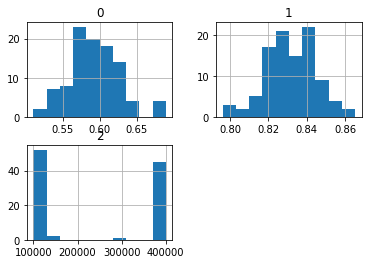

In [31]:
pd.DataFrame(param_GLM_outs).hist()
print(pd.DataFrame(param_GLM_outs).std(0))
plt.show()

In [20]:
lookahead = 10

interval = city.Date.iloc[-1] - city.Date.iloc[0]
times = range(interval.days+lookahead)

est_total_cases_GLM = GLM(times, r = param_GLM[0], p = param_GLM[1], K = param_GLM[2])
upp_total_cases_GLM = GLM(times, r = param_GLM[0]+param_GLM_sds[0], p = param_GLM[1]+param_GLM_sds[1], K = param_GLM[2]+param_GLM_sds[2])
low_total_cases_GLM = GLM(times, r = param_GLM[0]-param_GLM_sds[0], p = param_GLM[1]-param_GLM_sds[1], K = param_GLM[2]-param_GLM_sds[2])

est_daily_cases_GLM = np.diff(est_total_cases_GLM)

dates = pd.date_range(start=city.Date.iloc[0],periods=interval.days+lookahead)

In [21]:
# Plot fitted data

fig = city.iplot(x='Date', y='TotalCases',
                 mode = 'lines+markers',
                 asFigure = True, 
                 title="Case count " + target,
                 yTitle="Total cases",
                 xTitle="Date")

fig.add_trace(go.Scatter(x=dates, y=est_total_cases_GLM, name='EstTotalCases (GLM)'))
fig.add_trace(go.Scatter(x=dates, y=upp_total_cases_GLM, name='EstTotalCases (GLM, upper)'))
fig.add_trace(go.Scatter(x=dates, y=low_total_cases_GLM, name='EstTotalCases (GLM, lower)'))

fig.add_trace(go.Bar(x=city.Date, y=city.IncidenceRate, name='Incidence Rate'))
fig.add_trace(go.Bar(x=dates, y=est_daily_cases_GLM, name='Est Incidence Rate (GLM)'))

fig.show()

In [22]:
param_RM_sds, param_RM_outs = param_sd(est_total_cases_RM, RM, pop=(10**6)/2, S=100)

print(param_RM)
print(param_RM_sds)
print(param_RM+param_RM_sds)
print(param_RM-param_RM_sds)

100
[9.99998275e+00 5.56198997e-03 1.67398763e+04]
[6.82409131e-01 3.95677990e-04 2.57518739e+01]
[1.06823919e+01 5.95766796e-03 1.67656281e+04]
[9.31757362e+00 5.16631198e-03 1.67141244e+04]


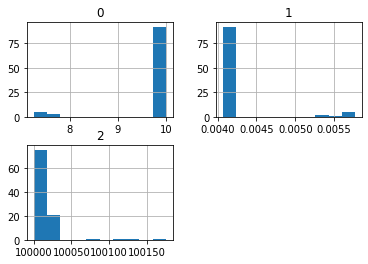

In [23]:
pd.DataFrame(param_RM_outs).hist()
plt.show()

In [24]:
lookahead = 10

interval = city.Date.iloc[-1] - city.Date.iloc[0]
times = range(interval.days+lookahead)

est_total_cases_RM = RM(times, r = param_RM[0], a = param_RM[1], K = param_RM[2])
upp_total_cases_RM = RM(times, r = param_RM[0]+param_RM_sds[0], a = param_RM[1]+param_RM_sds[1], K = param_RM[2]+param_RM_sds[2])
low_total_cases_RM = RM(times, r = param_RM[0]-param_RM_sds[0], a = param_RM[1]-param_RM_sds[1], K = param_RM[2]-param_RM_sds[2])

est_daily_cases_RM = np.diff(est_total_cases_RM)

dates = pd.date_range(start=city.Date.iloc[0],periods=interval.days+lookahead)

In [25]:
# Plot fitted data

fig = city.iplot(x='Date', y='TotalCases',
                 mode = 'lines+markers',
                 asFigure = True, 
                 title="Case count " + target,
                 yTitle="Total cases",
                 xTitle="Date")

fig.add_trace(go.Scatter(x=dates, y=est_total_cases_RM, name='EstTotalCases (RM)'))
fig.add_trace(go.Scatter(x=dates, y=upp_total_cases_RM, name='EstTotalCases (RM, upper)'))
fig.add_trace(go.Scatter(x=dates, y=low_total_cases_RM, name='EstTotalCases (RM, lower)'))

fig.add_trace(go.Bar(x=city.Date, y=city.IncidenceRate, name='Incidence Rate'))
fig.add_trace(go.Bar(x=dates, y=est_daily_cases_RM, name='Est Incidence Rate (RM)'))

fig.show()